In [ ]:
import numpy as np
import pandas as pd
from math import sqrt
from pandas import DataFrame
from pandas import read_csv
from pandas import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

<ipython-input-5-0534c83bc219>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [ ]:
data = pd.read_csv("btc_6h.csv")
data.head()

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13155.38,13558.99,2421.241182
1,2018-01-01 11:30:00,13539.00,13818.55,13001.13,13220.56,1876.934392
2,2018-01-01 17:30:00,13220.56,13330.00,12750.00,13022.00,2427.898747
3,2018-01-01 23:30:00,13007.87,13599.70,12940.00,13380.00,1883.841523
4,2018-01-02 05:30:00,13382.16,13850.00,12890.02,13166.95,3957.954564


In [ ]:
data.shape

(5959, 6)

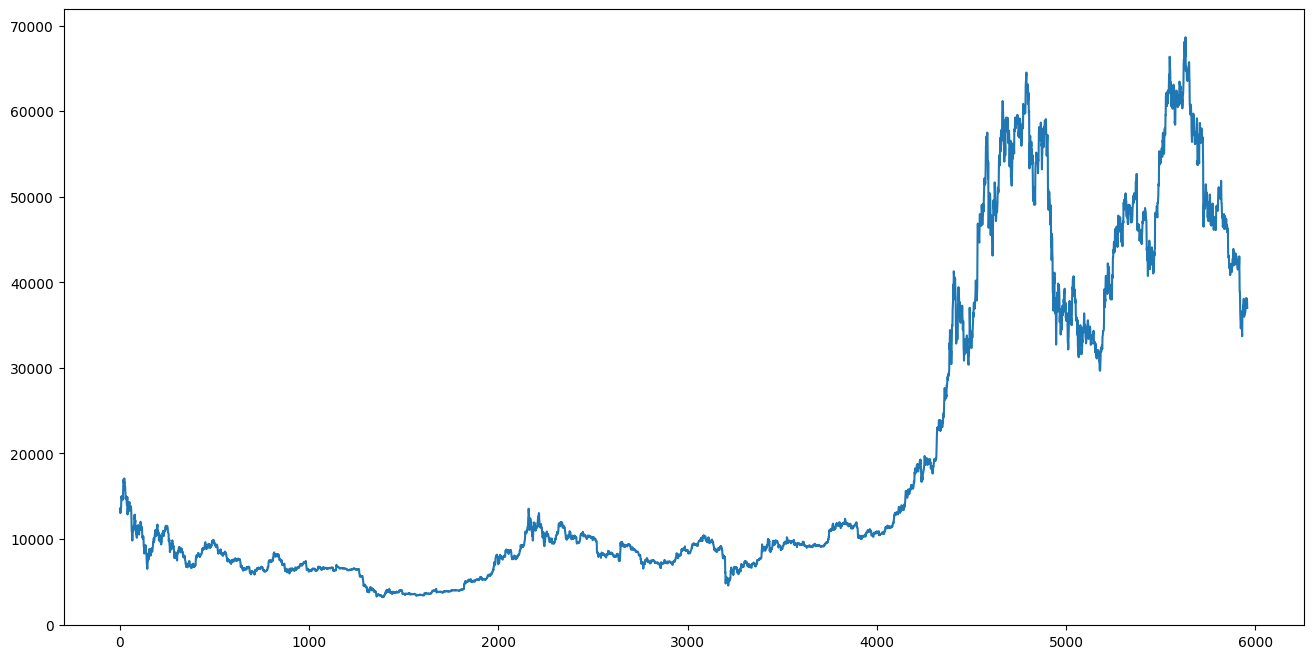

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data['close'])
plt.show()

In [ ]:
close_data = data['close']
close_data
close_df = pd.DataFrame(close_data,columns =['close'])
close_df.head()

,close
0,13558.99
1,13220.56
2,13022.00
3,13380.00
4,13166.95


In [ ]:
data['next'] = data['close'].shift(-1)

In [ ]:
data.head()

,datetime,open,high,low,close,volume,next
0,2018-01-01 05:30:00,13715.65,13715.65,13155.38,13558.99,2421.241182,13220.56
1,2018-01-01 11:30:00,13539.00,13818.55,13001.13,13220.56,1876.934392,13022.00
2,2018-01-01 17:30:00,13220.56,13330.00,12750.00,13022.00,2427.898747,13380.00
3,2018-01-01 23:30:00,13007.87,13599.70,12940.00,13380.00,1883.841523,13166.95
4,2018-01-02 05:30:00,13382.16,13850.00,12890.02,13166.95,3957.954564,13490.00


In [ ]:
data.dtypes

datetime     object
open        float64
high        float64
low         float64
close       float64
volume      float64
next        float64
dtype: object

Checking Autocorrelation for Time Series Analysis

In [ ]:
# Split into train and test sets
X = data['next'].values
size = int(len(X) * 0.8)

# Split first 80% for training
X_train_3 = X[:size]

# Split next 10% (80-90%) for validation
validation_size = int(size + 0.1 * len(X))
X_val_3 = X[size:validation_size]

# Split last 10% (90-100%) for testing
X_test_3 = X[validation_size:]

# Initialize a list to store prediction history
history = [x for x in X_train_3]

In [ ]:
# Walk-forward validation using ARIMA model for validation data

val_pred = list()
for t in range(len(X_val_3)):
    # Fit ARIMA model on the training data
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next value
    output = model_fit.forecast()
    yhat = output[0]

    # Append the predicted value to the list of predictions
    val_pred.append(yhat)

    # Update the history with the observed value
    obs = X_val_3[t]
    history.append(obs)

    # Print the predicted and expected values for each iteration
    print('Predicted=%f, Expected=%f' % (yhat, obs))

Predicted=56449.352711, Expected=57749.090000
Predicted=57790.745149, Expected=58077.520000
Predicted=58039.688244, Expected=57947.670000
Predicted=57975.702948, Expected=58527.190000
Predicted=58477.811413, Expected=58405.080000
Predicted=58369.520184, Expected=58142.540000
Predicted=58147.735753, Expected=60851.920000
Predicted=60865.864873, Expected=60575.940000
Predicted=60582.521684, Expected=60100.480000
Predicted=60154.732337, Expected=59769.130000
Predicted=59615.336320, Expected=59679.970000
Predicted=59649.409020, Expected=59721.840000
Predicted=59745.818620, Expected=59864.390000
Predicted=59889.257077, Expected=60002.430000
Predicted=60014.944585, Expected=60207.010000
Predicted=60212.119147, Expected=60241.500000
Predicted=60236.902664, Expected=59749.400000
Predicted=59735.284896, Expected=59860.000000
Predicted=59847.693290, Expected=60668.740000
Predicted=60670.487553, Expected=62942.210000
Predicted=63017.221342, Expected=63332.850000
Predicted=63361.224265, Expected=6

In [ ]:
# Convert validation and predictions to DataFrames for plotting
val_df = DataFrame(X_val_3, index=data['next'].index[size:validation_size], columns=['Actual'])
val_pred_df = DataFrame(val_pred, index=data['next'].index[size:validation_size], columns=['Predicted'])

# Evaluate forecasts for validation data
mse_val = mean_squared_error(val_df, val_pred_df)
rmse_val = np.sqrt(mse_val)

# Calculate R-squared (R^2) score for validation data
r2_val = r2_score(val_df, val_pred_df)

# Calculate Mean Absolute Error (MAE) for validation data
mae_val = mean_absolute_error(val_df, val_pred_df)

# Calculate Mean Absolute Percentage Error (MAPE) for validation data
mape_val = np.mean(np.abs((np.array(val_df) - np.array(val_pred_df)) / np.array(val_df))) * 100

# Print results for validation data
print(f'Mean Squared Error (MSE) for Validation Data: {mse_val:.3f}')
print(f'Root Mean Squared Error (RMSE) for Validation Data: {rmse_val:.3f}')
print(f'R-squared (R^2) Score for Validation Data: {r2_val:.3f}')
print(f'Mean Absolute Error (MAE) for Validation Data: {mae_val:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Validation Data: {mape_val:.3f}%')

Mean Squared Error (MSE) for Validation Data: 932577.839
Root Mean Squared Error (RMSE) for Validation Data: 965.701
R-squared (R^2) Score for Validation Data: 0.989
Mean Absolute Error (MAE) for Validation Data: 693.863
Mean Absolute Percentage Error (MAPE) for Validation Data: 1.642%


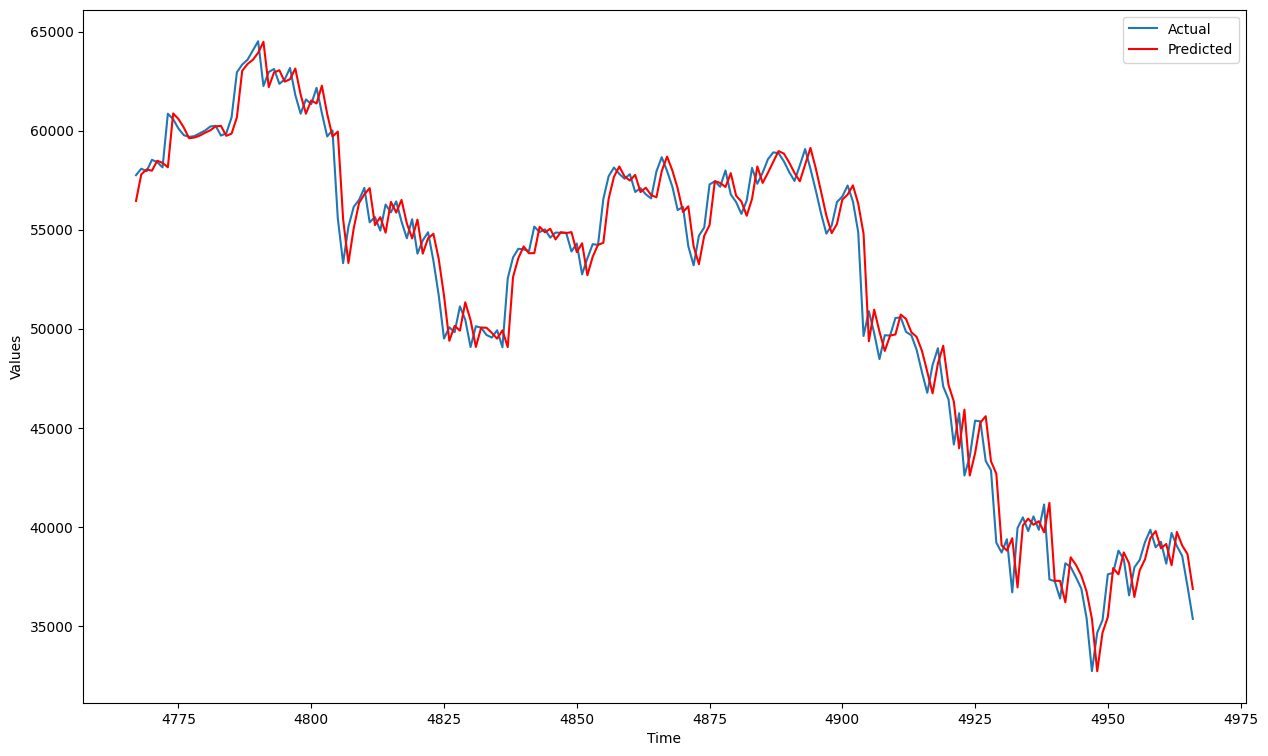

In [ ]:
# Set the range you want to zoom in on
start_index = 0
end_index = 200

# Extract data for the specified range
actual_values = val_df['Actual'].iloc[start_index:end_index]
predicted_values = val_pred_df['Predicted'].iloc[start_index:end_index]
time_index = val_df.index[start_index:end_index]

# Set the plot size
plt.figure(figsize=(15, 9))

# Plot actual values
plt.plot(time_index, actual_values, label='Actual')

# Plot predicted values in red
plt.plot(time_index, predicted_values, color='red', label='Predicted')

# Add labels to the axes
plt.xlabel('Time')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
test_pred = list()
for t in range(len(X_test_3)):
    # Fit ARIMA model on the training data
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next value
    output = model_fit.forecast()
    yhat = output[0]

    # Append the predicted value to the list of predictions
    test_pred.append(yhat)

    # Update the history with the observed value
    obs = X_test_3[t]
    history.append(obs)

    # Print the predicted and expected values for each iteration
    print('Predicted=%f, Expected=%f' % (yhat, obs))

Predicted=50218.486700, Expected=49902.940000
Predicted=49895.272380, Expected=49954.830000
Predicted=49967.925273, Expected=49915.640000
Predicted=49908.857240, Expected=49688.800000
Predicted=49712.322045, Expected=50198.780000
Predicted=50192.276097, Expected=50299.690000
Predicted=50313.714785, Expected=51756.880000
Predicted=51753.309211, Expected=51759.990000
Predicted=51748.482311, Expected=51400.670000
Predicted=51361.442140, Expected=51672.980000
Predicted=51562.700552, Expected=52663.900000
Predicted=52653.924334, Expected=52665.010000
Predicted=52699.426042, Expected=50941.480000
Predicted=50918.689516, Expected=46606.440000
Predicted=46515.777212, Expected=46863.730000
Predicted=46838.041004, Expected=46074.840000
Predicted=46298.972919, Expected=46394.090000
Predicted=46685.705054, Expected=46200.190000
Predicted=46240.944935, Expected=46048.310000
Predicted=46088.807306, Expected=46304.440000
Predicted=46290.000418, Expected=46293.150000
Predicted=46311.733075, Expected=4

In [ ]:
# Convert test and predictions to DataFrames for plotting
test_df = DataFrame(X_test_3, index=data['next'].index[validation_size:], columns=['Actual'])
test_pred_df = DataFrame(test_pred, index=data['next'].index[validation_size:], columns=['Predicted'])

In [ ]:
test_df.drop(test_df.tail(1).index, inplace=True)

In [ ]:
test_pred_df.drop(test_pred_df.tail(1).index, inplace=True)

In [ ]:
# Evaluate forecasts for test data
mse_test = mean_squared_error(test_df, test_pred_df)
rmse_test = np.sqrt(mse_test)

# Calculate R-squared (R^2) score for test data
r2_test = r2_score(test_df, test_pred_df)

# Calculate Mean Absolute Error (MAE) for test data
mae_test = mean_absolute_error(test_df, test_pred_df)

# Calculate Mean Absolute Percentage Error (MAPE) for test data
mape_test = np.mean(np.abs((np.array(test_df) - np.array(test_pred_df)) / np.array(test_df))) * 100

# Print results for test data
print(f'Mean Squared Error (MSE) for Test Data: {mse_test:.3f}')
print(f'Root Mean Squared Error (RMSE) for Test Data: {rmse_test:.3f}')
print(f'R-squared (R^2) Score for Test Data: {r2_test:.3f}')
print(f'Mean Absolute Error (MAE) for Test Data: {mae_test:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Test Data: {mape_test:.3f}%')

Mean Squared Error (MSE) for Test Data: 772822.537
Root Mean Squared Error (RMSE) for Test Data: 879.103
R-squared (R^2) Score for Test Data: 0.988
Mean Absolute Error (MAE) for Test Data: 598.761
Mean Absolute Percentage Error (MAPE) for Test Data: 1.191%


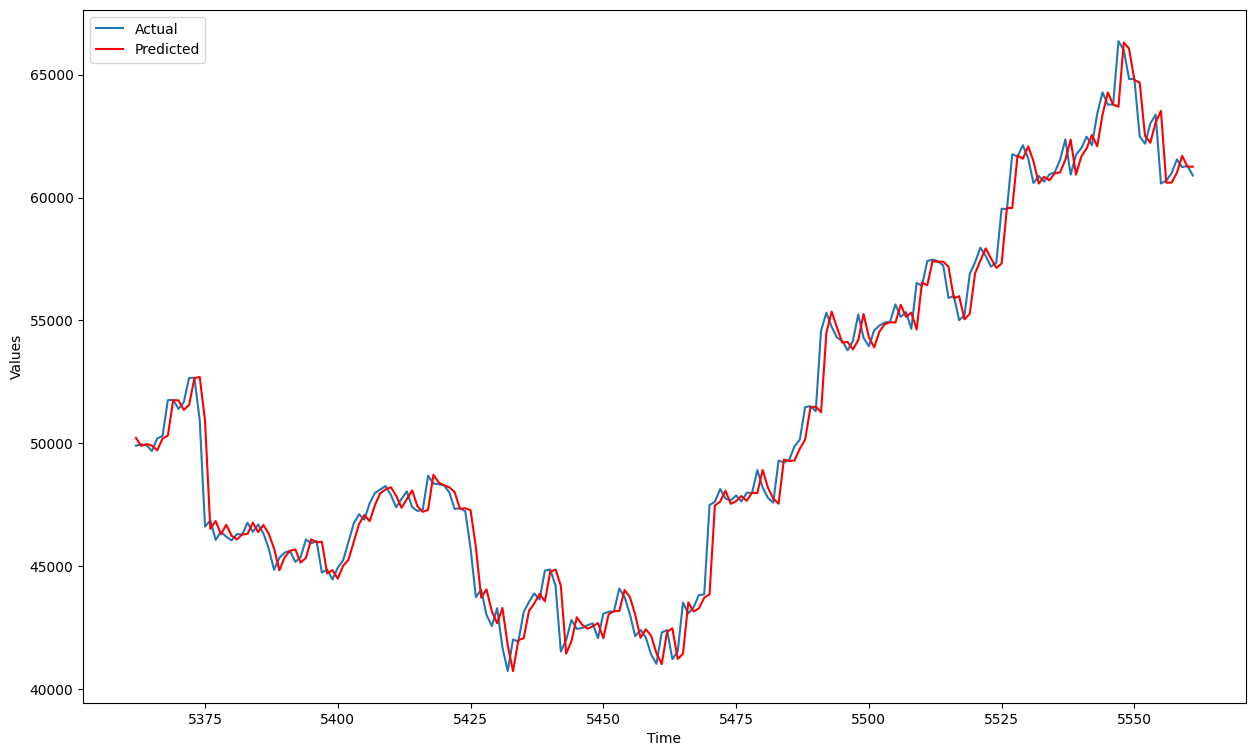

In [ ]:
# Set the range you want to zoom in on
start_index = 0
end_index = 200

# Extract data for the specified range
actual_values_test = test_df['Actual'].iloc[start_index:end_index]
predicted_values_test = test_pred_df['Predicted'].iloc[start_index:end_index]
time_index_test = test_df.index[start_index:end_index]

# Set the plot size
plt.figure(figsize=(15, 9))

# Plot actual values
plt.plot(time_index_test, actual_values_test, label='Actual')

# Plot predicted values in red
plt.plot(time_index_test, predicted_values_test, color='red', label='Predicted')

# Add labels to the axes
plt.xlabel('Time')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the plot
plt.show()

## Out sample Testing

In [ ]:
out_sample_test_2023 = pd.read_csv('BTC-USD.csv')

In [ ]:
outsample_test_data = list(out_sample_test_2023['Close'].values)
history_all = list(data['close'].values)

In [ ]:
outsample_test_data

[38743.273438,
 36952.984375,
 37154.601563,
 41500.875,
 41441.164063,
 42412.433594,
 43840.285156,
 44118.445313,
 44338.796875,
 43565.113281,
 42407.9375,
 42244.46875,
 42197.515625,
 42586.917969,
 44575.203125,
 43961.859375,
 40538.011719,
 40030.976563,
 40122.15625,
 38431.378906,
 37075.28125,
 38286.027344,
 37296.570313,
 38332.609375,
 39214.21875,
 39105.148438,
 37709.785156,
 43193.234375,
 44354.636719,
 43924.117188,
 42451.789063,
 39137.605469,
 39400.585938,
 38419.984375,
 38062.039063,
 38737.269531,
 41982.925781,
 39437.460938,
 38794.972656,
 38904.011719,
 37849.664063,
 39666.753906,
 39338.785156,
 41143.929688,
 40951.378906,
 41801.15625,
 42190.652344,
 41247.824219,
 41077.996094,
 42358.808594,
 42892.957031,
 43960.933594,
 44348.730469,
 44500.828125,
 46820.492188,
 47128.003906,
 47465.730469,
 47062.664063,
 45538.675781,
 46281.644531,
 45868.949219,
 46453.566406,
 46622.675781,
 45555.992188,
 43206.738281,
 43503.847656,
 42287.664063,
 4278

In [ ]:
predictions = []
for t in range(len(outsample_test_data)):
    Model = ARIMA(history_all, order = (5,1,0))
    Model_fit = Model.fit()
    output = Model_fit.forecast(steps = 30)
    y_hat = output[0]
    predictions.append(y_hat)
    observation = outsample_test_data[t]
    history_all.append(observation)

    print('Predicted=%f, Expected=%f' % (y_hat, observation))


Predicted=36999.540328, Expected=38743.273438
Predicted=38756.675728, Expected=36952.984375
Predicted=36968.914762, Expected=37154.601563
Predicted=37185.451677, Expected=41500.875000
Predicted=41434.502308, Expected=41441.164063
Predicted=41507.161028, Expected=42412.433594
Predicted=42421.398515, Expected=43840.285156
Predicted=43592.397070, Expected=44118.445313
Predicted=44047.907032, Expected=44338.796875
Predicted=44288.171100, Expected=43565.113281
Predicted=43464.804605, Expected=42407.937500
Predicted=42360.163566, Expected=42244.468750
Predicted=42223.929242, Expected=42197.515625
Predicted=42237.290412, Expected=42586.917969
Predicted=42669.289307, Expected=44575.203125
Predicted=44616.982730, Expected=43961.859375
Predicted=43967.786841, Expected=40538.011719
Predicted=40496.988246, Expected=40030.976563
Predicted=39912.817162, Expected=40122.156250
Predicted=40129.961485, Expected=38431.378906
Predicted=38630.985590, Expected=37075.281250
Predicted=37162.641232, Expected=3

In [ ]:
#converting vlaues to dataframe
predictions_df = pd.DataFrame( predictions,columns = ['predictions'])
outsample_df = pd.DataFrame(outsample_test_data, columns = ['close'])
print(outsample_df.shape , predictions_df.shape)

(704, 1) (704, 1)


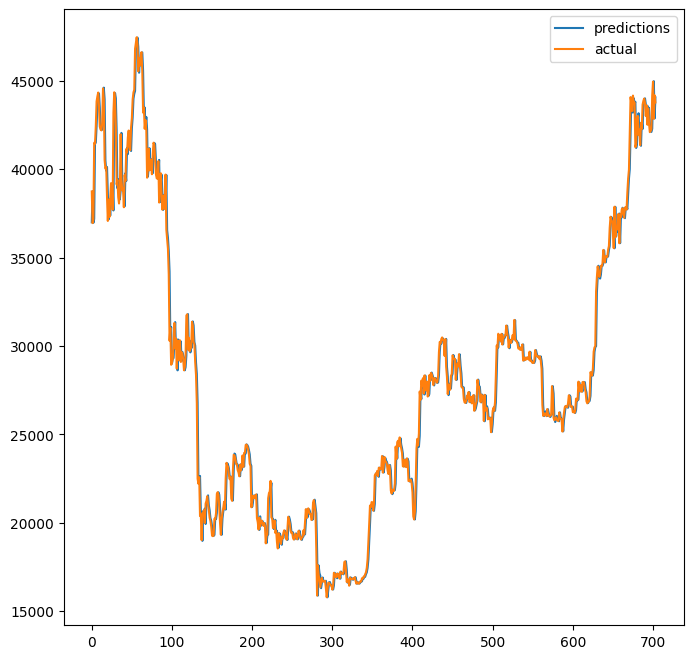

In [ ]:

plt.figure(figsize = (8,8))
plt.plot(predictions_df['predictions'], label = "predictions")
plt.plot(outsample_df['close'], label = "actual")
plt.legend()
plt.show()


In [ ]:
mse_outsample_test = mean_squared_error(predictions_df,outsample_df)
rmse_outsample_test = sqrt(mse_outsample_test)
r2_outsample_test = r2_score(predictions_df, outsample_df)
mae_outsample_test = mean_absolute_error(predictions_df, outsample_df)
mape_outsample_test = np.mean(np.abs((np.array(predictions_df) - np.array(outsample_df)) / np.array(outsample_df))) * 100

print(f'Mean Squared Error (MSE) for Test Data: {mse_outsample_test:.3f}')
print(f'Root Mean Squared Error (RMSE) for Test Data: {rmse_outsample_test:.3f}')
print(f'R-squared (R^2) Score for Test Data: {r2_outsample_test:.3f}')
print(f'Mean Absolute Error (MAE) for Test Data: {mae_outsample_test:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Test Data: {mape_outsample_test:.3f}%')

Mean Squared Error (MSE) for Test Data: 718891.941
Root Mean Squared Error (RMSE) for Test Data: 847.875
R-squared (R^2) Score for Test Data: 0.989
Mean Absolute Error (MAE) for Test Data: 542.010
Mean Absolute Percentage Error (MAPE) for Test Data: 1.905%


In [ ]:
out_sample_returns = out_sample_test_2023['Close'].pct_change()
returns = pd.DataFrame(np.array(out_sample_returns),columns = ['actual'])
returns

,actual
0,NaN
1,-0.046209
2,0.005456
3,0.116978
4,-0.001439
...,...
699,0.045005
700,0.017901
701,-0.046928
702,0.031081


In [ ]:
predictions_df['return'] = predictions_df['predictions'].pct_change()
predictions_df

,predictions,return
0,36999.540328,NaN
1,38756.675728,0.047491
2,36968.914762,-0.046128
3,37185.451677,0.005857
4,41434.502308,0.114266
...,...,...
699,42286.222421,0.004109
700,44201.472082,0.045293
701,44982.351664,0.017666
702,42875.174008,-0.046845


In [ ]:
return_df = pd.DataFrame(np.array(out_sample_returns),columns = ['actual'])
return_df['prediction'] = predictions_df['return']
#return_df.drop(return_df.head(1).index, inplace = True)
return_df

,actual,prediction
0,NaN,NaN
1,-0.046209,0.047491
2,0.005456,-0.046128
3,0.116978,0.005857
4,-0.001439,0.114266
...,...,...
699,0.045005,0.004109
700,0.017901,0.045293
701,-0.046928,0.017666
702,0.031081,-0.046845


In [ ]:
return_df['actual_close'] = out_sample_test_2023['Close']
return_df['prediction_close'] = predictions_df['predictions']
return_df.head(10)

,actual,prediction,actual_close,prediction_close
0,NaN,NaN,38743.273438,36999.540328
1,-0.046209,0.047491,36952.984375,38756.675728
2,0.005456,-0.046128,37154.601563,36968.914762
3,0.116978,0.005857,41500.875000,37185.451677
4,-0.001439,0.114266,41441.164063,41434.502308
5,0.023437,0.001754,42412.433594,41507.161028
6,0.033666,0.022026,43840.285156,42421.398515
7,0.006345,0.027604,44118.445313,43592.397070
8,0.004995,0.010449,44338.796875,44047.907032
9,-0.017449,0.005455,43565.113281,44288.171100


In [ ]:
return_df['actual_return'] = return_df['actual'].cumsum()
return_df['strat_return'] = return_df['prediction'].cumsum()
return_df

,actual,prediction,actual_close,prediction_close,actual_return,strat_return
0,NaN,NaN,38743.273438,36999.540328,NaN,NaN
1,-0.046209,0.047491,36952.984375,38756.675728,-0.046209,0.047491
2,0.005456,-0.046128,37154.601563,36968.914762,-0.040753,0.001363
3,0.116978,0.005857,41500.875000,37185.451677,0.076225,0.007220
4,-0.001439,0.114266,41441.164063,41434.502308,0.074786,0.121487
...,...,...,...,...,...,...
699,0.045005,0.004109,44167.332031,42286.222421,0.420326,0.423415
700,0.017901,0.045293,44957.968750,44201.472082,0.438227,0.468707
701,-0.046928,0.017666,42848.175781,44982.351664,0.391299,0.486374
702,0.031081,-0.046845,44179.921875,42875.174008,0.422379,0.439529


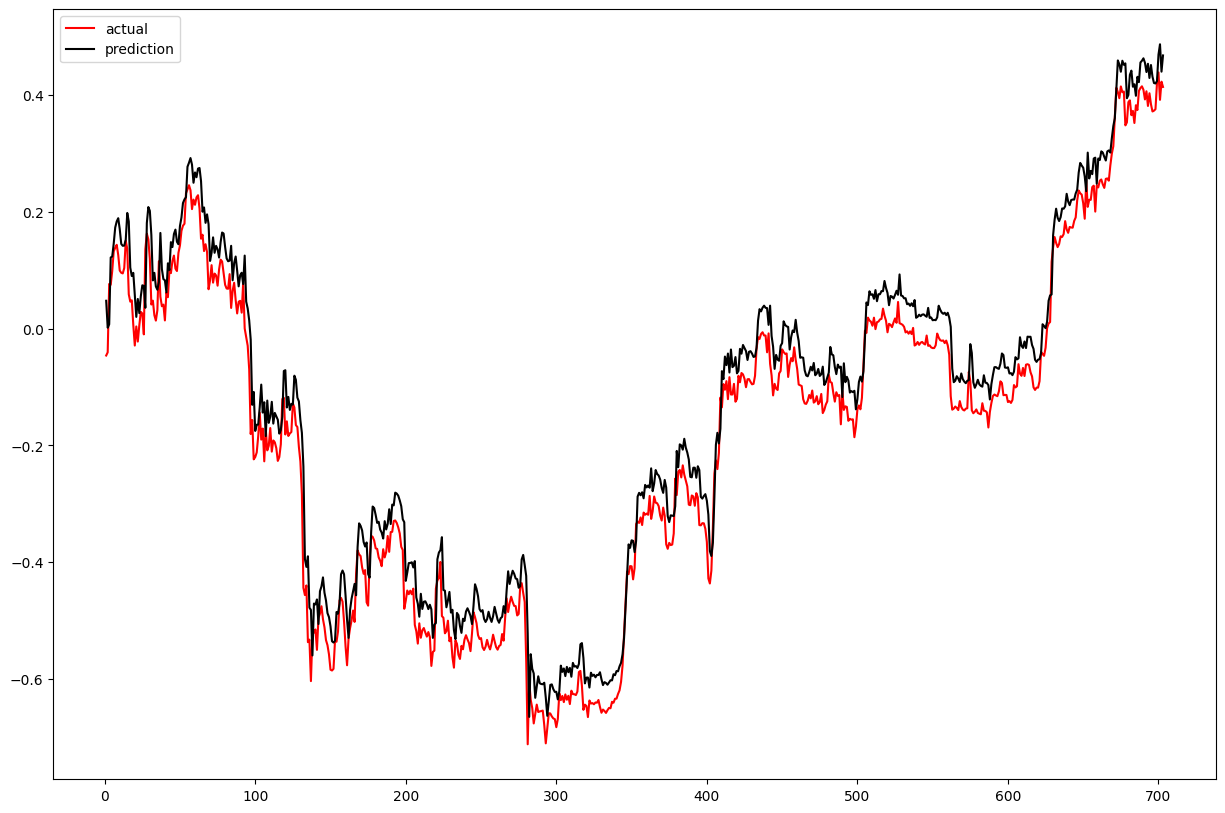

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(return_df['actual_return'] , label = 'actual', color = 'red')
plt.plot(return_df['strat_return'], label = 'prediction', color = 'black')
plt.legend()
plt.show()

# Creating a trading startergy

In [ ]:
prediction_close = return_df['prediction_close']
actual_close = return_df['actual_close']

# TRADING STARTERGY

### 1. Create a threshold value - This value determine we will take a action or just pass




### 2. if the prediction value passes the threshold in positive direction we will buy the stock else we will sell the stock at current price
            

In [ ]:
# Replace this with the actual risk-free rate
# [Random value taken]
risk_free_rate = 0.02

Mean = prediction_close[0]
threshold = -0.08
steps = 50
net_earning = 0
total_investment = 100000  # USD 100,000
current_money = total_investment
current_investment = 0
bitcoin_count = 0

returns = []  # To store daily returns

for i in range(0, len(return_df) - steps):
    future = prediction_close[i + steps]
    current = prediction_close[i]
    change = (future - current) / current

    returns.append(change)

    if change < threshold and current_investment != 0:
        # Sell
        current_money = bitcoin_count * current
        current_investment = 0

    elif current_investment == 0:
        # Buy
        current_investment = current_money
        bitcoin_count = current_investment / current

    else:
        continue

if current_investment == 0:
    net_earning = current_money
else:
    net_earning = current_investment

# Profits
profits = net_earning - total_investment

# Calculate Sharpe Ratio
average_return = np.mean(returns) * 252  # Assuming 252 trading days in a year
volatility = np.std(returns) * np.sqrt(252)  # Annualized volatility
sharpe_ratio = (average_return - risk_free_rate) / volatility

print(f"Net Earning: {net_earning}")
print(f"Profits: {profits}")
print(f"Sharpe Ratio: {sharpe_ratio}")

Net Earning: 154178.52387083374
Profits: 54178.52387083374
Sharpe Ratio: 1.8171401528495648
